<a href="https://colab.research.google.com/github/LaurensEiroa/Narma10-System-Identification/blob/master/EchoStateNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as linfit

In [0]:
m = 1 # Number of input channels
n = 400 # Number of reservoir nodes
t = 800 # Length of the serie

# Normalized Root Mean Square Error
NRMSE = lambda y,y_fit: np.mean(((y-y_fit)**2)/np.var(y))

## Input channel and reservoir connections
# Some random initialized weights work better than others, to improve 
# performance, try creating new connection weights
w_in = np.random.randint(-1, 2, (m, n))
w_res = np.random.normal(0, 1, (n, n))
w_res = w_res/max(np.absolute(np.linalg.eigvals(w_res)))

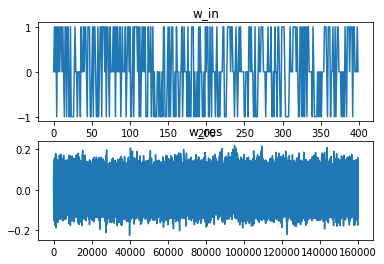

In [0]:
visual_w_in = w_in.reshape((w_in.size))
visual_w_res = w_res.reshape((w_res.size))
fig,ax = plt.subplots(nrows=2)
ax[0].plot(range(visual_w_in.size),visual_w_in)
ax[0].set_title("w_in")
ax[1].plot(range(visual_w_res.size),visual_w_res)
ax[1].set_title("w_res")
plt.show()

In [0]:
def create_data(t):
  u = np.random.uniform(0,0.5,t) # Input values
  # NARMA sequence
  y = np.zeros(t)
  for i in range(t-1):
    sum_t = np.sum(y[0:i]) if i <= 9 else np.sum(y[i-9:i+1])
    if i <= 9:
      y[i+1] = 0.3 * y[i] + 0.05 * sum_t * y[i] + 0.1
    else:
      y[i+1] = 0.3 * y[i] + 0.05 * sum_t * y[i] + 1.5 * u[i] * u[i - 9] + 0.1
  u = u[np.newaxis,20:]
  y = y[np.newaxis,20:]
  return u, y

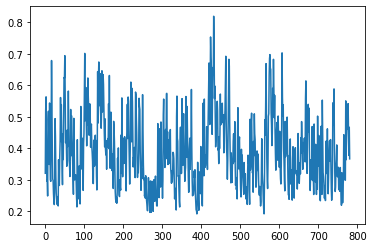

In [0]:
u, y = create_data(t)
x = np.linspace(0,u.shape[1],u.shape[1])
# Visualize the NARMA sequence
plt.plot(x,y[0])
plt.show()

In [0]:
def fit_model(u, w_in, w_res,inputgain, feedbackgain,y_train=None,train=False):
  # Compute the reservoir state
  reservoir_state = np.zeros((w_res.shape[0],u.shape[1]))
  for i in range(u.shape[1]):
    if i == 0:
      reservoir_state[:,i] = np.tanh(inputgain*w_in.T@u[:,i])
    else:
      reservoir_state[:,i] = np.tanh(inputgain*w_in.T@u[:,i] + feedbackgain*w_res.T@reservoir_state[:,i-1])
  # Add one bias node for a better amplitude in the linear fit
  reservoir_state = np.concatenate((reservoir_state,np.ones((1,reservoir_state.shape[1]))),axis=0)
  w_out = None
  if train:
    # Use Tikhonov Regularization to fit the model and generalize on unseen data
    regression = linfit.BayesianRidge(n_iter=3000, tol=1e-6, verbose=True, fit_intercept=False)
    # Remove the first element of the resevoir since does not consider the previous state of the reservoir
    regression.fit(reservoir_state[:,1:].T, y_train[0,1:])
    w_out = regression.coef_
  return w_out, reservoir_state

In [0]:
inputgain = 0.1
feedbackgain = 0.95

wout, state = fit_model(u, w_in, w_res,inputgain, feedbackgain, y_train=y, train=True)
y_fit = wout.T@state

error = NRMSE(y,y_fit)
print(error)

0.017454275393540292


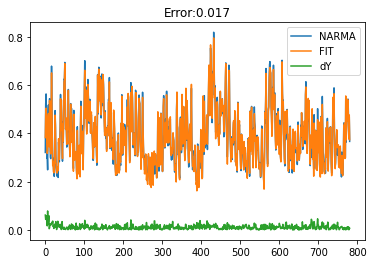

In [0]:
plt.plot(x[:],y[0,:],label="NARMA")
plt.plot(x[:],y_fit[:],label="FIT")
plt.plot(x[:],np.abs(y[0,:]-y_fit[:]),label="dY")
plt.legend()
plt.title("Error:"+str(round(error,3)))
plt.show()

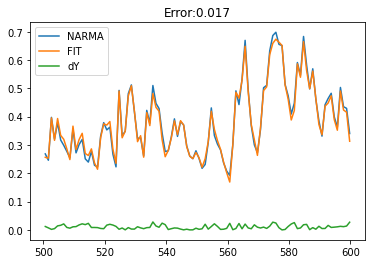

In [0]:
plt.plot(x[500:600],y[0,500:600],label="NARMA")
plt.plot(x[500:600],y_fit[500:600],label="FIT")
plt.plot(x[500:600],np.abs(y[0,500:600]-y_fit[500:600]),label="dY")
plt.legend()
plt.title("Error:"+str(round(error,3)))
plt.show()

In [0]:
# Test the configuration for an unseen data set
u_test,y_test = create_data(t)
_, state_test = fit_model(u_test, w_in, w_res,inputgain, feedbackgain)
y_fit_test = wout.T@state_test
error_test = NRMSE(y_test,y_fit_test)
print(error_test)

0.06982494120003546


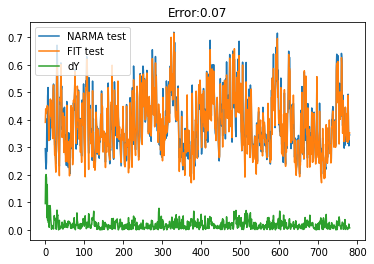

In [0]:
plt.plot(x[:],y_test[0,:],label="NARMA test")
plt.plot(x[:],y_fit_test[:],label="FIT test")
plt.plot(x[:],np.abs(y_test[0,:]-y_fit_test[:]),label="dY")
plt.legend()
plt.title("Error:"+str(round(error_test,3)))
plt.show()

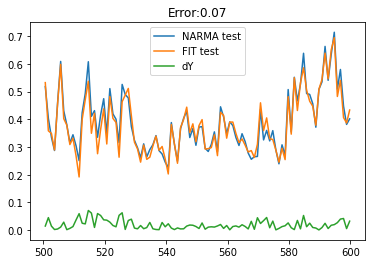

In [0]:
# Zoom on validation
plt.plot(x[500:600],y_test[0,500:600],label="NARMA test")
plt.plot(x[500:600],y_fit_test[500:600],label="FIT test")
plt.plot(x[500:600],np.abs(y_test[0,500:600]-y_fit_test[500:600]),label="dY")

plt.legend()
plt.title("Error:"+str(round(error_test,3)))
plt.show()